In [1]:
%matplotlib widget

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
import h5py
import os
import torch
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'
import numpy as np
from tqdm.autonotebook import tqdm
import os
from BasisConvolution.util.dataloader import datasetLoader, processFolder#, DataLoader
from BasisConvolution.util.hyperparameters import defaultHyperParameters
from BasisConvolution.util.dataPlotting import getFileCount, getPreparePlotFunction, getUpdatePlotFunction
import matplotlib.pyplot as plt
import ipywidgets as widgets

/tmp/ipykernel_2890754/3069418549.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [96]:
hyperParameterDict = defaultHyperParameters()

hyperParameterDict['batch_size'] = 1
hyperParameterDict['maxRollOut'] = 0
hyperParameterDict['maxUnroll'] = 0

hyperParameterDict['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
hyperParameterDict['device'] = 'cpu'

hyperParameterDict['augmentAngle'] = False
hyperParameterDict['augmentJitter'] = False
hyperParameterDict['zeroOffset'] = False


datasetPath = '/home/winchenbach/dev/diffSPH/partiBench/generator/export'

train_ds = datasetLoader(processFolder(hyperParameterDict, datasetPath))

In [97]:
len([f for f in train_ds.fileNames if 'free-slip' in f and not 'wObstacle' in f])

freeSlip_noObstacle = [f for f in train_ds.fileNames if 'free-slip' in f and not 'wObstacle' in f]
freeSlip_withObstacle = [f for f in train_ds.fileNames if 'free-slip' in f and 'wObstacle' in f]
noSlip_noObstacle = [f for f in train_ds.fileNames if 'zero' in f and not 'wObstacle' in f]
noSlip_withObstacle = [f for f in train_ds.fileNames if 'zero' in f and 'wObstacle' in f]
periodic = [f for f in train_ds.fileNames if 'none' in f]

print(f'freeSlip_noObstacle: {len(freeSlip_noObstacle)}')
print(f'freeSlip_withObstacle: {len(freeSlip_withObstacle)}')
print(f'noSlip_noObstacle: {len(noSlip_noObstacle)}')
print(f'noSlip_withObstacle: {len(noSlip_withObstacle)}')
print(f'periodic: {len(periodic)}')

freeSlip_noObstacle: 20
freeSlip_withObstacle: 20
noSlip_noObstacle: 20
noSlip_withObstacle: 20
periodic: 20


In [98]:

from BasisConvolution.util.augment import augmentState, loadAugmentedFrame, loadFrame
from BasisConvolution.util.plotting import setPlotBaseAttributes, prepVisualizationState, visualizeParticleQuantity

config, attributes, currentState, priorState, trajectoryStates = loadAugmentedFrame(0, train_ds, hyperParameterDict)

In [99]:
def fileToLabel(fName):
    fName = fName.split('/')[-1]
    split = fName.split('_')
    offset = 1 if 'Obstacle' in fName else 0

    BC = 'free-slip' if 'free-slip' in fName else 'no-slip'
    BC = 'periodic' if 'none' in fName else BC

    if 'TGV' in fName:
        attr = split[3 + offset]
        attrs = attr.split('x')
        k = int(float(attrs[2]))
        prefix = 'TGV'
        return f'{BC} {prefix} k={k}'
    else: 
        attr = split[2 + offset]
        attrs = attr.split('x')
        prefix = 'gen'
        # print(attrs)
        baseFrequency = int(float(attrs[2]))
        octaves = int(float(attrs[3]))
        return f'{BC} {prefix} {baseFrequency} x {octaves}'
    return fName

[fileToLabel(f) for f in noSlip_withObstacle]

['no-slip gen 1 x 1',
 'no-slip gen 1 x 2',
 'no-slip gen 1 x 3',
 'no-slip gen 1 x 4',
 'no-slip gen 2 x 1',
 'no-slip gen 2 x 2',
 'no-slip gen 2 x 3',
 'no-slip gen 2 x 4',
 'no-slip gen 4 x 1',
 'no-slip gen 4 x 2',
 'no-slip gen 4 x 3',
 'no-slip gen 4 x 4',
 'no-slip gen 8 x 1',
 'no-slip gen 8 x 2',
 'no-slip gen 8 x 3',
 'no-slip gen 8 x 4',
 'no-slip TGV k=1',
 'no-slip TGV k=2',
 'no-slip TGV k=3',
 'no-slip TGV k=4']

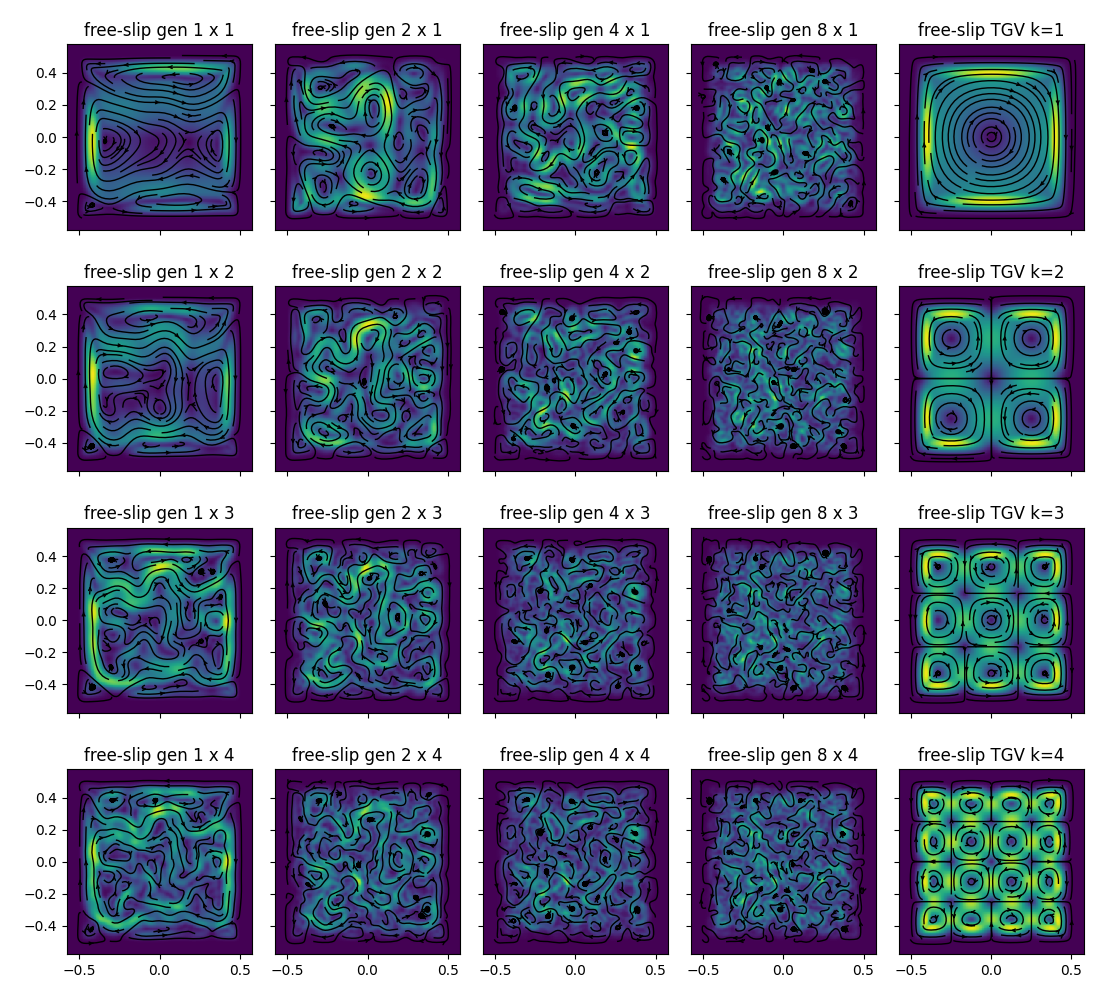

In [110]:
fig, axis = plt.subplots(4,5, figsize=(11,10), sharex=True, sharey=True)

for ax in axis.flatten():
    setPlotBaseAttributes(ax, config)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])

freeSlip_noObstacle = [f for f in train_ds.fileNames if 'free-slip' in f and not 'wObstacle' in f]
freeSlip_withObstacle = [f for f in train_ds.fileNames if 'free-slip' in f and 'wObstacle' in f]
noSlip_noObstacle = [f for f in train_ds.fileNames if 'zero' in f and not 'wObstacle' in f]
noSlip_withObstacle = [f for f in train_ds.fileNames if 'zero' in f and 'wObstacle' in f]
periodic = [f for f in train_ds.fileNames if 'none' in f]

for i, (ax, file) in enumerate(zip(axis.T.flatten(), freeSlip_noObstacle)):
# for i, (ax, file) in enumerate(zip(axis.T.flatten(), freeSlip_withObstacle)):
# for i, (ax, file) in enumerate(zip(axis.T.flatten(), noSlip_noObstacle)):
# for i, (ax, file) in enumerate(zip(axis.T.flatten(), noSlip_withObstacle)):
# for i, (ax, file) in enumerate(zip(axis.T.flatten(), periodic)):
    # if not 'TGV' in file:
        # continue
    try:
        if getFileCount(file) < 4000:
            print('Broken Simulation in ', file)
        # config, attributes, currentState, priorState, trajectoryStates = loadFrame([file, '%05d' % getFileCount(file), None, 0, None], train_ds, hyperParameterDict, 0)
        config, attributes, currentState, priorState, trajectoryStates = loadFrame([file, '00001', None, 0, None], train_ds, hyperParameterDict, 0)
    except Exception as e:
        print(getFileCount(file), e)
        continue
    visState = prepVisualizationState(currentState, config, nGrid = 255)
    positions = visState['fluid']['positions']
    # ax.scatter(positions.cpu()[:,0],positions.cpu()[:,1], s=0.5, c = currentState['fluid']['indices'].cpu(), cmap = 'twilight_r')
    
    # indexPlot = visualizeParticleQuantity(fig, ax, config, visState, quantity = 'indices', mapping = '.x', s = 0.5, 
                            # scaling = 'lin', gridVisualization=False, cmap = 'twilight_r', title = fileToLabel(file), plotBoth=True, which = 'fluid', cbar = False)
    indexPlot = visualizeParticleQuantity(fig, ax, config, visState, quantity = 'velocities', mapping = 'L2', s = 0.5, 
                            scaling = 'lin', gridVisualization=True, cmap = 'viridis',streamLines = True, title = fileToLabel(file), plotBoth=True, which = 'fluid', cbar = False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    # break

    # ax.set_title(fileToLabel(file))

    # break

fig.tight_layout()

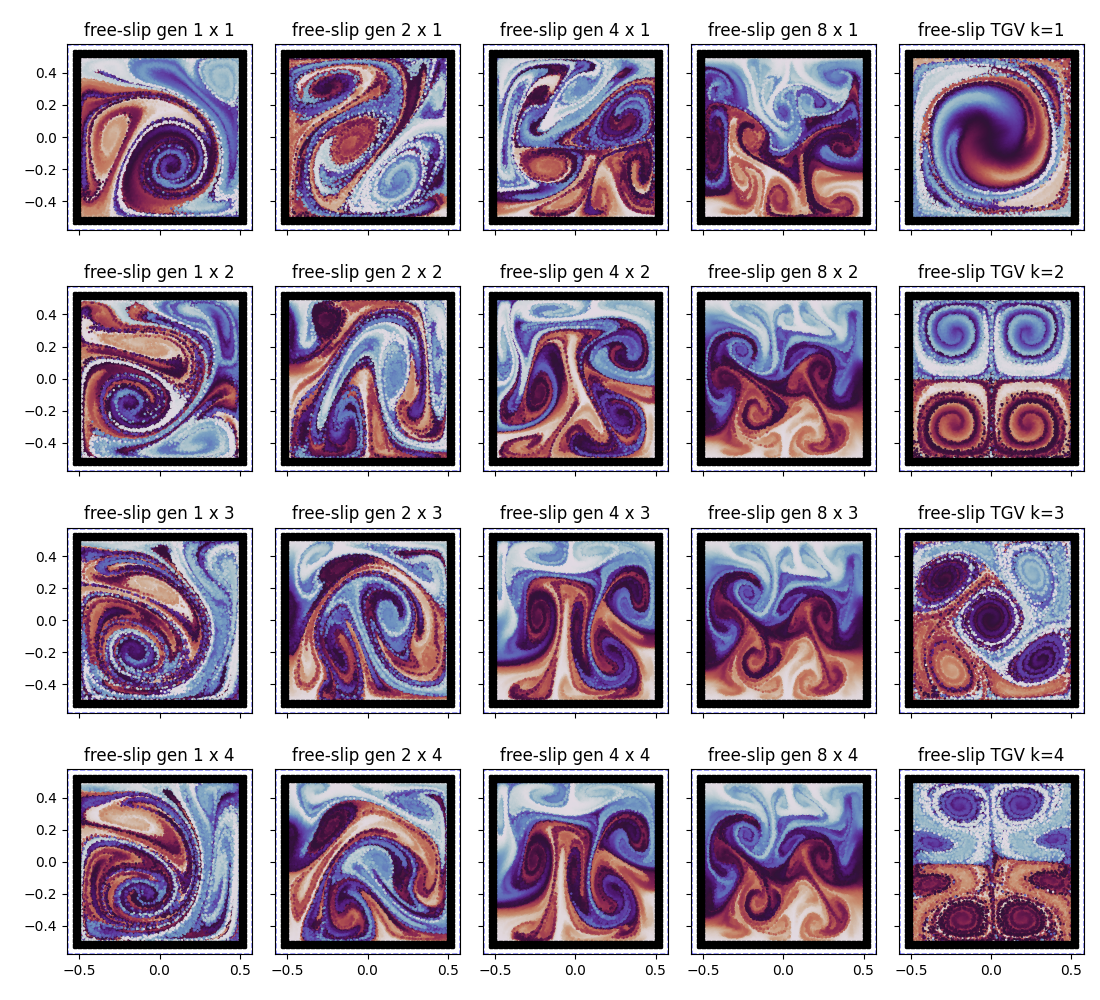

In [111]:
fig, axis = plt.subplots(4,5, figsize=(11,10), sharex=True, sharey=True)

for ax in axis.flatten():
    setPlotBaseAttributes(ax, config)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])

freeSlip_noObstacle = [f for f in train_ds.fileNames if 'free-slip' in f and not 'wObstacle' in f]
freeSlip_withObstacle = [f for f in train_ds.fileNames if 'free-slip' in f and 'wObstacle' in f]
noSlip_noObstacle = [f for f in train_ds.fileNames if 'zero' in f and not 'wObstacle' in f]
noSlip_withObstacle = [f for f in train_ds.fileNames if 'zero' in f and 'wObstacle' in f]
periodic = [f for f in train_ds.fileNames if 'none' in f]

for i, (ax, file) in enumerate(zip(axis.T.flatten(), freeSlip_noObstacle)):
# for i, (ax, file) in enumerate(zip(axis.T.flatten(), freeSlip_withObstacle)):
# for i, (ax, file) in enumerate(zip(axis.T.flatten(), noSlip_noObstacle)):
# for i, (ax, file) in enumerate(zip(axis.T.flatten(), noSlip_withObstacle)):
# for i, (ax, file) in enumerate(zip(axis.T.flatten(), periodic)):
    # if not 'TGV' in file:
        # continue
    try:
        if getFileCount(file) < 4000:
            print('Broken Simulation in ', file)
        config, attributes, currentState, priorState, trajectoryStates = loadFrame([file, '%05d' % getFileCount(file), None, 0, None], train_ds, hyperParameterDict, 0)
        # config, attributes, currentState, priorState, trajectoryStates = loadFrame([file, '00001', None, 0, None], train_ds, hyperParameterDict, 0)
    except Exception as e:
        print(getFileCount(file), e)
        continue
    visState = prepVisualizationState(currentState, config, nGrid = 256)
    positions = visState['fluid']['positions']
    # ax.scatter(positions.cpu()[:,0],positions.cpu()[:,1], s=0.5, c = currentState['fluid']['indices'].cpu(), cmap = 'twilight_r')
    
    indexPlot = visualizeParticleQuantity(fig, ax, config, visState, quantity = 'indices', mapping = '.x', s = 0.5, 
                            scaling = 'lin', gridVisualization=False, cmap = 'twilight_r', title = fileToLabel(file), plotBoth=True, which = 'fluid', cbar = False)
    # indexPlot = visualizeParticleQuantity(fig, ax, config, visState, quantity = 'velocities', mapping = 'L2', s = 0.5, 
                            # scaling = 'lin', gridVisualization=True, cmap = 'viridis',streamLines = True, title = fileToLabel(file), plotBoth=True, which = 'fluid', cbar = False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    # break

    # ax.set_title(fileToLabel(file))

    # break

fig.tight_layout()